# Sector Coupling

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa pandas numpy matplotlib highspy "plotly<6"
```
:::

In [1]:
import pypsa
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.offline as py
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"

## Previous electricity-only PyPSA model

To explore sector-coupling options with PyPSA, let's load the capacity expansion model we built for the electricity system and add sector-coupling technologies and demands on top. 

Some of the sector-coupling technologies we are going to add have multiple ouputs (e.g. CHP plants producing heat and power). PyPSA can automatically handle links have more than one input (`bus0`)
and/or output (i.e. `bus1`, `bus2`, `bus3`) with a given efficieny (`efficiency`, `efficiency2`, `efficiency3`).

In [3]:
url = "https://tubcloud.tu-berlin.de/s/5SZzniw9YHkNJPJ/download/electricity-network.nc"
n = pypsa.Network(url)

INFO:pypsa.io:Retrieving network data from https://tubcloud.tu-berlin.de/s/5SZzniw9YHkNJPJ/download/electricity-network.nc
INFO:pypsa.io:Imported network electricity-network.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [4]:
n

Unnamed PyPSA Network
---------------------
Components:
 - Bus: 1
 - Carrier: 5
 - Generator: 3
 - GlobalConstraint: 1
 - Load: 1
 - StorageUnit: 2
Snapshots: 2920

## Hydrogen Production

The following example shows how to model the components of hydrogen storage separately, i.e. electrolysis, fuel cell and storage.

First, let's remove the simplified hydrogen storage representation:

In [5]:
n.remove("StorageUnit", "hydrogen storage underground")

Add a separate `Bus` for the hydrogen energy carrier:

In [6]:
n.add("Bus", "hydrogen", carrier='hydrogen')

Index(['hydrogen'], dtype='object')

Add a `Link` for the hydrogen electrolysis:

In [7]:
n.add(
    "Link",
    "electrolysis",
    bus0="electricity",
    bus1="hydrogen",
    carrier="electrolysis",
    p_nom_extendable=True,
    efficiency=0.7,
    capital_cost=50e3,  # €/MW/a
)

Index(['electrolysis'], dtype='object')

Add a `Link` for the fuel cell which reconverts hydrogen to electricity:

In [8]:
n.add(
    "Link",
    "fuel cell",
    bus0="hydrogen",
    bus1="electricity",
    carrier="fuel cell",
    p_nom_extendable=True,
    efficiency=0.5,
    capital_cost=120e3,  # €/MW/a
)

Index(['fuel cell'], dtype='object')

Add a `Store` for the hydrogen storage:

In [9]:
n.add(
    "Store",
    "hydrogen storage",
    bus="hydrogen",
    carrier="hydrogen storage",
    capital_cost=140,  # €/MWh/a
    e_nom_extendable=True,
    e_cyclic=True,  # cyclic state of charge
)

Index(['hydrogen storage'], dtype='object')

We can also add a hydrogen demand to the hydrogen bus.

In the example below, we add a constant hydrogen demand the size of the electricity demand.

In [10]:
p_set = n.loads_t.p_set["demand"].mean()

In [11]:
p_set

7564.622045662099

In [12]:
n.add("Load", "hydrogen demand", bus="hydrogen", carrier="hydrogen", p_set=p_set)  # MW

Index(['hydrogen demand'], dtype='object')

When we now optimize the model with additional hydrogen demand...

In [13]:
n.optimize()

Index(['electrolysis', 'fuel cell'], dtype='object', name='Link')
Index(['wind'], dtype='object', name='Generator')
Index(['hydrogen storage'], dtype='object', name='Store')
Index(['electricity', 'hydrogen'], dtype='object', name='Bus')
Index(['hydrogen demand'], dtype='object', name='Load')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 332.14it/s]
INFO:linopy.io: Writing time: 0.26s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-mncw78dd has 64248 rows; 29207 cols; 129985 nonzeros
Coefficient ranges:
  Matrix [2e-04, 4e+00]
  Cost   [3e-02, 1e+05]
  Bound  [0e+00, 0e+00]
  RHS    [5e+03, 1e+04]
Presolving model
33618 rows, 24864 cols, 89174 nonzeros  0s
Dependent equations search running on 8760 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
30698 rows, 21944 cols, 83334 nonzeros  0s
Presolve : Reductions: rows 30698(-33550); columns 21944(-7263); elements 83334(-46651)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 5840(2.92041e+09) 0s
      15699     1.0429829996e+10 Pr: 10132(6.32311e+11); Du: 0(3.0275e-07) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 29207 primals, 64248 duals
Objective: 1.25e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


      20431     1.2495660063e+10 Pr: 0(0) 8s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-mncw78dd
Model status        : Optimal
Simplex   iterations: 20431
Objective value     :  1.2495660063e+10
Relative P-D gap    :  5.2508465051e-14
HiGHS run time      :          8.24
Writing the solution to /tmp/linopy-solve-npmdz4sh.sol


('ok', 'optimal')

...we can see the individual sizing of the electrolyser, fuel cell and hydrogen storage:

In [14]:
n.statistics.optimal_capacity().div(1e3).round(2)

component    carrier         
Link         electrolysis          21.42
             fuel cell              8.05
Generator    solar                 55.43
             wind                  54.05
Store        hydrogen storage    5591.08
StorageUnit  battery storage       15.68
dtype: float64

Furthermore, we might want to explore the storage state of charge of the hydrogen storage and the balancing patterns:

In [15]:
n.stores_t.e.div(1e6).plot() # TWh

## Heat Demand

For modelling simple heating systems, we create another bus and connect a load with the heat demand time series to it.

In [16]:
n.add("Bus", "heat", carrier='heat')

Index(['heat'], dtype='object')

In [17]:
url = "https://tubcloud.tu-berlin.de/s/8KWqTAHEM9m8dFj/download/heat-demand.csv"
p_set = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()[::3]

In [18]:
n.add("Load", "heat demand", carrier="heat", bus="heat", p_set=p_set)

Index(['heat demand'], dtype='object')

In [19]:
n.loads_t.p_set.div(1e3).plot()

What is now missing are a few heat supply options...

## Heat pumps

To model heat pumps, first we have to calculate the **coefficient of performance (COP)** profile based on the temperature profile of the heat source.

In the example below, we calculate the COP for an air-sourced heat pump with a sink temperature of 55° C and a population-weighted ambient temperature profile for Germany.

The heat pump performance is assumed to be given by the following function:

$$
COP(\Delta T) = 6.81 - 0.121 \Delta T + 0.00063^\Delta T^2
$$
where $\Delta T = T_{sink} - T_{source}$.

In [20]:
def cop(t_source, t_sink=55):
    delta_t = t_sink - t_source
    return 6.81 - 0.121 * delta_t + 0.000630 * delta_t**2

In [21]:
url = "https://tubcloud.tu-berlin.de/s/Ym7Gzozw7pjYzNz/download/temperature.csv"
temp = pd.read_csv(url, index_col=0, parse_dates=True).squeeze()[::3]

In [22]:
cop(temp).plot()

Text(0, 0.5, 'COP [-]')

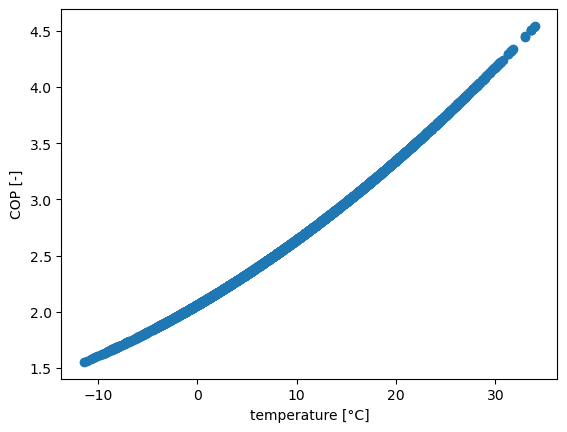

In [23]:
plt.scatter(temp, cop(temp))
plt.xlabel("temperature [°C]")
plt.ylabel("COP [-]")

Once we have calculated the heat pump coefficient of performance, we can add the heat pump to the network as a `Link`. We use the parameter `efficiency` to incorporate the COP.

In [24]:
n.add(
    "Link",
    "heat pump",
    carrier="heat pump",
    bus0="electricity",
    bus1="heat",
    efficiency=cop(temp),
    p_nom_extendable=True,
    capital_cost=3e5,  # €/MWe/a
)

Index(['heat pump'], dtype='object')

Let's also add a resistive heater as backup technology:

In [25]:
n.add(
    "Link",
    "resistive heater",
    carrier="resistive heater",
    bus0="electricity",
    bus1="heat",
    efficiency=0.9,
    capital_cost=1e4,  # €/MWe/a
    p_nom_extendable=True,
)

Index(['resistive heater'], dtype='object')

## Combined Heat-and-Power (CHP)

In the following, we are going to add gas-fired combined heat-and-power plants (CHPs). Today, these would use fossil gas, but in the example below we assume imported green methane or methanol with relatively high marginal costs. Since we have no other net emission technology, we can remove the CO$_2$ limit.

In [26]:
n.remove("GlobalConstraint", "CO2Limit")

Then, we explicitly represent the energy carrier gas:

In [27]:
n.add("Bus", "gas", carrier="gas")

Index(['gas'], dtype='object')

And add a `Store` of gas, which can be depleted (up to 100 TWh) with fuel costs of 180 €/MWh.

In [28]:
n.add(
    "Store",
    "gas storage",
    carrier="gas storage",
    e_initial=100e6,  # MWh
    e_nom=100e6,  # MWh
    bus="gas",
    marginal_cost=180,  # €/MWh_th
)

Index(['gas storage'], dtype='object')

When we do this, we have to model the OCGT power plant as link which converts gas to electricity, not as generator.

In [29]:
n.remove("Generator", "OCGT")

In [30]:
n.add(
    "Link",
    "OCGT",
    bus0="gas",
    bus1="electricity",
    carrier="OCGT",
    p_nom_extendable=True,
    capital_cost=20000,  # €/MW/a
    efficiency=0.4,
)

Index(['OCGT'], dtype='object')

Next, we are going to add a combined heat-and-power (CHP) plant with fixed heat-power ratio (i.e. backpressure operation).

:::{note}
If you want to model flexible heat-power ratios, have a look at this example: https://pypsa.readthedocs.io/en/latest/examples/power-to-gas-boiler-chp.html
:::

In [31]:
n.add(
    "Link",
    "CHP",
    bus0="gas",
    bus1="electricity",
    bus2="heat",
    carrier="CHP",
    p_nom_extendable=True,
    capital_cost=40000,
    efficiency=0.4,
    efficiency2=0.4,
)

Index(['CHP'], dtype='object')

Now, let's optimize the current status of model:

In [32]:
n.optimize()

Index(['electrolysis', 'fuel cell', 'heat pump', 'resistive heater', 'CHP'], dtype='object', name='Link')
Index(['wind'], dtype='object', name='Generator')
Index(['hydrogen storage', 'gas storage'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'heat', 'gas'], dtype='object', name='Bus')
Index(['hydrogen demand', 'heat demand'], dtype='object', name='Load')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 240.22it/s]
INFO:linopy.io: Writing time: 0.38s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-ulw4tf7x has 96370 rows; 43810 cols; 194227 nonzeros
Coefficient ranges:
  Matrix [2e-04, 5e+00]
  Cost   [3e-02, 3e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 1e+08]
Presolving model
51337 rows, 40211 cols, 142331 nonzeros  0s
Dependent equations search running on 14056 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
46042 rows, 34916 cols, 131741 nonzeros  0s
Presolve : Reductions: rows 46042(-50328); columns 34916(-8894); elements 131741(-62486)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      19778     4.7814175027e+09 Pr: 11730(2.55162e+12); Du: 0(3.54824e-07) 5s
      24859     6.0066321552e+09 Pr: 7808(4.89767e+11); Du: 0(4.15804e-07) 11s
      31274     9.9620086809e+09 Pr: 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43810 primals, 96370 duals
Objective: 1.85e+10
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


Relative P-D gap    :  3.9228466186e-15
HiGHS run time      :         29.62
Writing the solution to /tmp/linopy-solve-277oirhe.sol


('ok', 'optimal')

The objective cost in bn€/a:

In [33]:
n.objective / 1e9

18.476187089241414

The heat energy balance (positive is supply, negative is consumption):

In [34]:
n.statistics.energy_balance(bus_carrier='heat').div(1e6).round(1)

component  carrier           bus_carrier
Link       heat pump         heat           52.9
           resistive heater  heat            7.8
           CHP               heat            4.9
Load       heat              heat          -65.7
Name: objective, dtype: float64

The heat energy balance as a time series:

In [35]:
n.statistics.energy_balance(aggregate_time=False, bus_carrier='heat').div(1e3).groupby("carrier").sum().T.plot()

## Long-duration heat storage

One technology of particular interest in district heating systems with large shares of renewables is long-duration thermal energy storage.

In the following, we are going to introduce a heat storage with investment cost of approximately 3 €/kWh.
The energy is not perfectly stored in water tanks. There are standing losses.
The decay of thermal energy in the heat storage is modelled through the function $1 - e^{-\frac{1}{24\tau}}$, where $\tau$ is assumed to be 180 days.
We want to see how that influences the optimal design decisions in the heating sector.

In [36]:
n.add(
    "Store",
    "heat storage",
    bus="heat",
    carrier="heat storage",
    capital_cost=300, # roughly annuity of 3 €/kWh
    standing_loss=1 - np.exp(-1 / 24 / 180),
    e_nom_extendable=True,
)

Index(['heat storage'], dtype='object')

In [37]:
n.optimize()

Index(['electrolysis', 'fuel cell', 'heat pump', 'resistive heater', 'CHP'], dtype='object', name='Link')
Index(['wind'], dtype='object', name='Generator')
Index(['hydrogen storage', 'gas storage', 'heat storage'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'heat', 'gas'], dtype='object', name='Bus')
Index(['hydrogen demand', 'heat demand'], dtype='object', name='Load')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 197.72it/s]
INFO:linopy.io: Writing time: 0.47s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-k188ivx4 has 105131 rows; 49651 cols; 214667 nonzeros
Coefficient ranges:
  Matrix [2e-04, 5e+00]
  Cost   [3e-02, 3e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 1e+08]
Presolving model
59896 rows, 48227 cols, 168008 nonzeros  0s
51138 rows, 39469 cols, 150492 nonzeros  0s
Dependent equations search running on 14202 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
50740 rows, 39071 cols, 151403 nonzeros  0s
Presolve : Reductions: rows 50740(-54391); columns 39071(-10580); elements 151403(-63264)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      19598     2.8493881545e+09 Pr: 10285(2.0667e+12); Du: 0(5.34986e-07) 6s
      25393     5.1803048850e+09 Pr: 11531(1.29532e+13); Du: 0(8.04716e

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 49651 primals, 105131 duals
Objective: 1.67e+10
Solver model: available
Solver message: Optimal



Model name          : linopy-problem-k188ivx4
Model status        : Optimal
Simplex   iterations: 51051
Objective value     :  1.6715475888e+10
Relative P-D gap    :  6.6181915157e-15
HiGHS run time      :         45.51
Writing the solution to /tmp/linopy-solve-agdrzftm.sol


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

The objective cost (in bn€/a) was reduced!

In [38]:
n.objective / 1e9

16.715475888094893

The heat energy balance shows the additional losses of the heat storage and the added supply:

In [39]:
n.statistics.energy_balance(bus_carrier='heat').div(1e6).round(1)

component  carrier           bus_carrier
Link       heat pump         heat           45.9
           resistive heater  heat           20.7
           CHP               heat            0.9
Store      heat storage      heat           -1.9
Load       heat              heat          -65.7
dtype: float64

The heat energy balance as a time series:

In [40]:
n.statistics.energy_balance(aggregate_time=False, bus_carrier='heat').div(1e3).groupby("carrier").sum().T.plot()

The different storage state of charge time series:

In [41]:
n.stores_t.e.plot()

The heat energy balance shows the additional losses of the heat storage and the added supply:

In [42]:
n.statistics.energy_balance(bus_carrier='electricity').sort_values().div(1e6).round(1)

component    carrier           bus_carrier
Link         electrolysis      electricity    -94.7
Load         -                 electricity    -66.3
Link         resistive heater  electricity    -23.0
             heat pump         electricity    -19.4
StorageUnit  battery storage   electricity     -0.2
Link         OCGT              electricity      0.2
             CHP               electricity      0.9
Generator    solar             electricity     40.2
             wind              electricity    162.2
dtype: float64

The heat energy balance as a time series:

In [43]:
n.statistics.energy_balance(aggregate_time=False, bus_carrier='electricity').div(1e3).groupby("carrier").sum().T.plot()

And it can tell you statistics about the capital expenditures:

In [44]:
n.statistics.capex().groupby("carrier").sum().div(1e9).sort_values().dropna().plot.bar()

And it can tell you statistics about the operational expenditures:

In [45]:
n.statistics.opex().groupby("carrier").sum().div(1e9).sort_values().dropna().plot.bar()

## Exercises

Explore how the model reacts to changing assumptions and available technologies. Here are a few inspirations, but choose in any order according to your interests:

- Assume underground hydrogen storage is not geographically available. Increase the cost of hydrogen storage by factor 10. How does the model react?
- Add a ground-sourced heat pump with a constant COP function of 3.5 but double the investment costs. Would this technology get built? How low would the costs need to be?
- Limit green gas imports to 10 TWh or even zero. What does the model do in periods with persistent low wind and solar feed-in but high heating demand?